In [1]:
ReLU is very simple. Take any negative value, replace it with zero. Take any positive value, keep it as it was.

def relu(x): 
    return x.clamp_min(0.)

negative_tensor = torch.tensor(-3)
negative_tensor

positive_tensor = torch.tensor(3)
positive_tensor

relu(negative_tensor)

relu(positive_tensor)

t = relu(lin(x_valid, w1, b1))

Once again, not normalized.

t.mean(), t.std()

![image.png](attachment:image.png)from pathlib import Path
import pickle
import gzip
import math
import os
import time
import shutil
import struct

import torch
from torch import tensor, clamp_min
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

# Convienience Methods & Setup

In [2]:
def relu(x): 
    return x.clamp_min(0.)

In [3]:
def lin(x, w, b):
    return x @ w + b

In [4]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [5]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [6]:
def return_params():
    n = x_train.shape[0]
    nh = 50
    bs = 50
    epochs = 3
    lr = 0.1
    
    return n, nh, bs, epochs, lr

In [7]:
def test_pred_without_training(x, y, mdl=None):
    
    if mdl is None:
        mdl = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
        opt = Optimizer(mdl.parameters())
    
    preds = mdl(x)
    loss = loss_func(preds, y.long())
    return report(loss, preds, y)

In [8]:
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [9]:
mpl.rcParams['image.cmap'] = 'gray'

# Data Preparation

In [10]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [11]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [255]:
def load_data():
    with gzip.open(path_gz, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
        
    x_train, y_train, x_valid, y_valid = map(lambda x: torch.from_numpy(x).float(),
                                             (x_train, y_train, x_valid, y_valid))
    
    return (x_train, y_train, x_valid, y_valid)

In [53]:
x_train, y_train, x_valid, y_valid = load_data()

In [54]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

In [55]:
type(x_train)

numpy.ndarray

In [56]:
x_train[0].shape

(784,)

In [57]:
x_train.shape

(50000, 784)

In [58]:
x_train.ndim

2

In [59]:
def normalize(x, m, s):
    return (x-m)/s

In [60]:
type(x_train)

numpy.ndarray

In [61]:
train_mean = x_train.mean()
train_std = x_train.std()

The mean is not 0, the std is not 1, which makes sense, because there's no praticulat reason for it to be so,
but we do want that so we'll normalize which just means substracting the mean and dividing by standard deviation.

In [62]:
train_mean, train_std

(0.13044983, 0.3072898)

In [63]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [64]:
x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

In [65]:
def test_near_zero(num: float, tol=1e-3):
    assert np.abs(num) < tol, f'Near zero {num}'

In [66]:
x_train.mean()

-3.1638146e-07

In [67]:
# passes
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [68]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [69]:
mpl.rcParams['image.cmap']

'gray'

In [70]:
mpl.rcParams['image.cmap'] = 'gray'

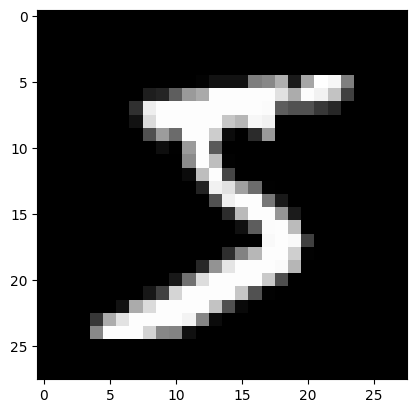

In [71]:
plt.imshow(x_train[0].reshape(28,28))

In [72]:
y_train[:3]

tensor([5, 0, 4])

In [73]:
y_train.min()

tensor(0)

In [74]:
y_train.max()

tensor(9)

initialize with random weights and bias. * we will later find out this random initializing is quite a bad idea
but more to come on that later

In [75]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [76]:
weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

# Matrix Multiplication

regular matrix multipication. For every row of left matrix, for every coloumn of right matrix, multiple and add
every intersection. for better visualization, see here http://matrixmultiplication.xyz/

In [86]:
def matmul_one(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [87]:
# we're going to multiplie the 5 first images in validation set with the random weights we gathered
imgs = x_valid[:5]
weights = weights

In [88]:
imgs.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [89]:
assert imgs.shape[1] == weights.shape[0]

In [81]:
imgs.shape

torch.Size([5, 784])

In [82]:
imgs.view(5, -1).shape

torch.Size([5, 784])

- view(5, -1): This reshapes the tensor to have 5 rows and automatically calculates the second dimension (28 * 28 = 784). The -1 tells PyTorch to infer the appropriate size for that dimension.
- You can also use .reshape(5, 784) if you prefer.

In [90]:
imgs.reshape(5, 784).shape

torch.Size([5, 784])

In [91]:
imgs = imgs.view(5, -1)

In [92]:
imgs.shape

torch.Size([5, 784])

In [93]:
assert imgs.shape[1] == weights.shape[0]

In [94]:
imgs.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [95]:
%timeit matmul_one(imgs, weights)

372 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
t1 = matmul_one(imgs, weights)

In [97]:
t1.shape

torch.Size([5, 10])

In [98]:
t1[0]

tensor([  6.8446, -34.5271,   7.5899,  -7.4181,   6.9764, -20.5725,  29.3994,
        -21.3841,  28.9898, -45.1712])

In [99]:
t1[0].max()

tensor(29.3994)

This simple matrix multiplication takes way too long. We want to do things faster, the way we would do that, is basically not use Python (as its too slow). We will write python, but the calculation will be done in C++.

The way we do this, is using PyTorch's element-wise operations which will behind the scences use the Aten C++ library. https://pytorch.org/cppdocs/. But there is some time until we get to that, lets make our way up, speeding up the process.

So this 1 line change will make things much faster. Instead of going through every intersection and adding it, we will multiple the entire column with the entire row, and only then sum it together. 

In [100]:
def matmul_two(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # this is the only different part from our previous loop.
            # the ":" after a[i] is redundant, only here for making
            # things clearer
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

521 microseconds. A thousand (!) times faster.

In [101]:
%timeit -n 10 _= matmul_one(imgs, weights)

363 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [102]:
%timeit -n 10 _= matmul_two(imgs, weights)

420 µs ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
411 * 1000 / 553 # 743 times faster

### Broadcasting

**broadcasting** describes how arrays with different shapes are handled during arithmetic operations.

In [103]:
a = tensor([5, -0.4, 7, -5 ])
a > 0

tensor([ True, False,  True, False])

This line above works as expected although it could seem a bit weird it does. We are checking if 0 is smaller then every one of those numbers in the a tensor, although 0 is just a scalar. The way it actually works is that 0 is being broadcasted, meaning some kind of "copied" (not really copied, memory wise) 4 times, so its actually only checking if each 0 is smaller then the respective number, we just have 4 times 0.

Its basically doing this, just not really copying, to save memory.

In [104]:
zeros = torch.zeros(4)

In [105]:
zeros

tensor([0., 0., 0., 0.])

In [108]:
a > zeros

tensor([ True, False,  True, False])

In [109]:
b = 0
a > b

tensor([ True, False,  True, False])

In [110]:
a = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = tensor([1, 2, 3])

This is what basically happens, b behaves as if it was expanded to the size needed to handle a 3 size tensor. What actually happened is that 

In [111]:
c = b.expand_as(a)
c

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [112]:
b.shape

torch.Size([3])

In [113]:
c.shape

torch.Size([3, 3])

we see c is actually stored once, not really 3 times. So how does this work ? 

In [114]:
c.storage()

/var/folders/30/hc9ysmcs0rz72fll1lphhpp00000gp/T/ipykernel_7433/1226304414.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  c.storage()


 1
 2
 3
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 3]

b (here named "c"), is just doing a 0 sized move every time it moves a line, and a 1 size move every time it moves a column, so for every row, it basically just does not move

In [116]:
a = tensor([3])
# one rank tensor
a.shape

torch.Size([1])

In [118]:
a.shape

torch.Size([1])

In [120]:
a.unsqueeze(1).shape

torch.Size([1, 1])

In [121]:
a[None].shape

torch.Size([1, 1])

In [122]:
a.unsqueeze(-1).shape

torch.Size([1, 1])

In [117]:
a.unsqueeze(1).shape == a[None].shape == a.unsqueeze(-1).shape

True

So lets reduce everything to 1 loop, we only loop through the rows in the left matrix and say: broadcast the first row in a to a 2 rank tensor so it can be multiplied with b and then sum everything on the first axis. Do this for every row in a. 

In [136]:
imgs.unsqueeze(-1).shape

torch.Size([5, 784, 1])

In [137]:
weights.shape

torch.Size([784, 10])

## Matmul Using Broadcasting

In [186]:
def matmul_three(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#         c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0) # this line and the next are the same
        c[i] = (a[i, :, None] * b).sum(dim=0) # take every row, all its columns and create another axis. This 
    # additional axis will be broadcasted to the size of b. This allows us to get rid of looping through b
    return c

In [187]:
%timeit -n 10 _= matmul_three(imgs, weights)

298 µs ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
%timeit -n 10 _= matmul_one(imgs, weights)

367 ms ± 5.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [157]:
411 * 1000 / 258

1593.0232558139535

Lastly, we will use the PyTorch function matmul (also works as @) which is by far the fastest. PyTorch uses a totally different way calculation. While Python has to use RAM memory again and again, PyTorch splits the calculation into separate parts and so is able to do things faster. *Pytorch doesn't really do it itself, it actually uses a linear algerbra library named BLAS (some companies like Intel, Nvidia etc have their own implementations for that). Bottom line - it works way faster. The down side is of course, we lose quite a lot of flexibility

Didnt we just say PyTorch is using a package called Aten?

ATen is the core library for PyTorch's tensor operations.
For linear algebra and other optimized operations, PyTorch can use BLAS on CPU (MKL, OpenBLAS, etc.) and cuBLAS on GPU.

In [189]:
imgs.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [191]:
%timeit -n 10 imgs @ weights

The slowest run took 7.88 times longer than the fastest. This could mean that an intermediate result is being cached.
27.4 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 matmul_one(imgs, weights)

Twenty five thousand (!!!) times faster.

In [ ]:
370 * 1000 / 15

# Normalization

## Random Weights Initialization

Start with fresh, unmanipulated data

In [313]:
x_train, y_train, x_valid, y_valid = load_data()

In [314]:
def normalize(x, mean, std):
    return (x - mean) / std

In [315]:
type(x_train)

torch.Tensor

In [312]:
train_mean = x_train.mean()
train_std = x_train.std()

The mean is not 1, the std is not 1, which makes sense, because there's no particular reason for it to be so,
but we do want that  cause it works less good, so we'll normalize which just means subtracting the mean and dividing by standard deviation.

In [279]:
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [280]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [281]:
x_train.mean(), x_train.std()

(tensor(2.1325e-08), tensor(1.))

In [282]:
train_mean = x_train.mean()
train_std = x_train.std()

In [283]:
def test_near_zero(num: float, tol=1e-3):
    assert np.abs(num) < tol, f'Near zero {num}'

In [284]:
# passes
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

So the problem is this: we want the inputs to any layer to be with a mean o 0 and std of 1. On the first layer, mission accomplished, we have it. Problem is .. if we initialize the weights randomly, the input to the second layer, won't be like this anymore. Lets see this

In [316]:
# number of hidden parameters
nh = 50

In [317]:
x_train.shape

torch.Size([50000, 784])

In [320]:
w1 = torch.randn(28*28, nh)
b1 = torch.randn(nh)

In [321]:
w1.shape, b1.shape

(torch.Size([784, 50]), torch.Size([50]))

In [322]:
x_valid.shape

torch.Size([10000, 784])

In [323]:
def lin(x, w, b):
    return x @ w + b

In [324]:
r1 = lin(x_valid, w1, b1)

In [325]:
type(x_valid), type(w1), type(b1)

(torch.Tensor, torch.Tensor, torch.Tensor)

In [326]:
x_valid.dtype, w1.dtype, b1.dtype

(torch.float32, torch.float32, torch.float32)

In [327]:
r1.shape

torch.Size([10000, 50])

In [328]:
r1.mean(), r1.std()

(tensor(-0.1188), tensor(8.7247))

## Kaming He Weights Initialization

In [329]:
x_train, y_train, x_valid, y_valid = load_data()

In [330]:
train_mean = x_train.mean()
train_std = x_train.std()

In [331]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [332]:
x_train.mean(), x_train.std()

(tensor(2.1325e-08), tensor(1.))

In [333]:
weights = torch.randn(784, 10)
imgs = x_valid[:5]

In [334]:
m = 784
nh = 50

Without normalizing the weights, after one linear process, the result will no longer be normalized

In [335]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [336]:
r2 = lin(x_valid, w1, b1)

In [337]:
r2.mean(), r2.std()

(tensor(0.6894), tensor(29.0576))

In [338]:
w1 = torch.randn(m, nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

Now, they ARE normalized

In [339]:
r2 = lin(x_valid, w1, b1)
r2.mean(), r2.std()

(tensor(-0.0009), tensor(0.9586))

# Activation Functions - See Separate Notebook

ReLU is very simple. Take any negative value, replace it with zero. Take any positive value, keep it as it was.

In [17]:
def relu(x): 
    return x.clamp_min(0.)

In [18]:
negative_tensor = torch.tensor(-3)
negative_tensor

tensor(-3)

In [19]:
positive_tensor = torch.tensor(3)
positive_tensor

tensor(3)

In [20]:
relu(negative_tensor)

tensor(0.)

In [21]:
relu(positive_tensor)

tensor(3.)

In [22]:
t = relu(lin(x_valid, w1, b1))

Once again, not normalized.

In [23]:
t.mean(), t.std()

(tensor(0.4322), tensor(0.6080))

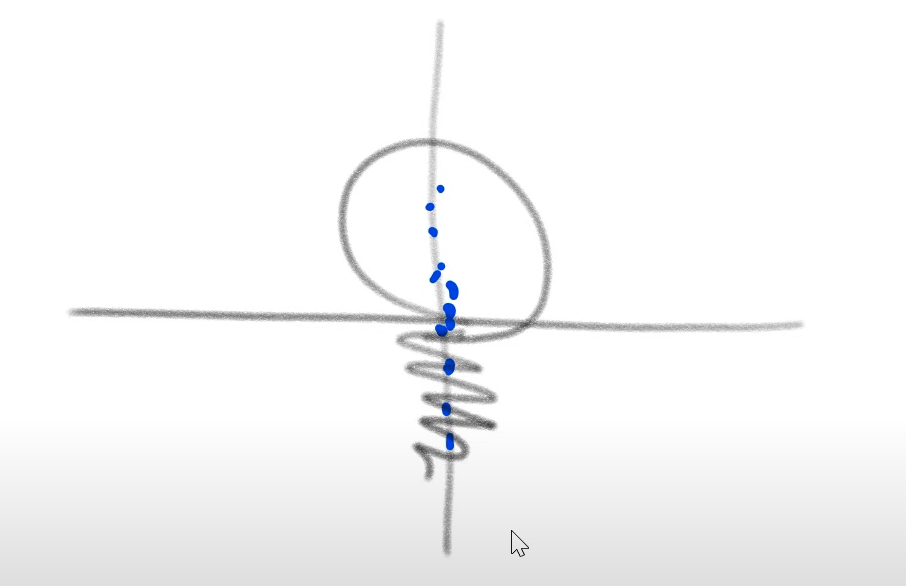